In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

2021-09-15 19:31:29.705779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-15 19:31:29.705874: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180
SPLIT = 0.2
CLASS_NUMBER = 5
EPOCHS = 10

In [3]:
def download_dataset(url, dir_name):
    data_dir = tf.keras.utils.get_file(dir_name, origin=url, untar=True)
    return pathlib.Path(data_dir)

In [4]:
def load_dataset(path):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    
    train = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        validation_split = SPLIT,
        subset = 'training',
        seed = 123,
        image_size = (IMG_HEIGHT, IMG_WIDTH),
        batch_size = BATCH_SIZE
    )
    
    validation = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        validation_split = SPLIT,
        subset = 'validation',
        seed = 123,
        image_size = (IMG_HEIGHT, IMG_WIDTH),
        batch_size = BATCH_SIZE
    )
    
    train = train.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    validation = validation.cache().prefetch(buffer_size = AUTOTUNE)
    
    return train, validation

In [5]:
def normalization(train_dataset):
    normalization_layer = layers.experimental.preprocessing.Rescaling(1. / 255)
    normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_dataset))
    
    return image_batch, labels_batch

In [6]:
class ImageClassifier(tf.keras.Model):
    def __init__(self, num_classes = CLASS_NUMBER, units = 128, padding = 'same', activation = 'relu', flip = 'horizontal', rotation = 0.1, zoom = 0.1, dropout = 0.2):
        super(ImageClassifier, self).__init__()
        self.random_flip = layers.experimental.preprocessing.RandomFlip(flip,
                                                                       input_shape = (IMG_HEIGHT, 
                                                                                      IMG_WIDTH, 
                                                                                      3))
        self.random_rotation = layers.experimental.preprocessing.RandomRotation(rotation)
        self.random_zoom = layers.experimental.preprocessing.RandomZoom(zoom)
        self.normalization = layers.experimental.preprocessing.Rescaling(1. / 255, input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))
        self.conv2d_1 = layers.Conv2D(16, 3, padding = padding, activation = activation)
        self.conv2d_2 = layers.Conv2D(32, 3, padding = padding, activation = activation)
        self.conv2d_3 = layers.Conv2D(64, 3, padding = padding, activation = activation)
        self.max_pooling2d = layers.MaxPooling2D()
        self.dropout = layers.Dropout(dropout)
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(units, activation = activation)
        self.dense_2 = layers.Dense(num_classes)
        
    def call(self, inputs, training = False):
        x = self.random_flip(inputs)
        x = self.random_rotation(x)
        x = self.random_zoom(x)
        x = self.normalization(x)
        x = self.conv2d_1(x)
        x = self.max_pooling2d(x)
        x = self.conv2d_2(x)
        x = self.max_pooling2d(x)
        x = self.conv2d_3(x)
        x = self.max_pooling2d(x)
        x = self.dropout(x, training = training)
        x = self.flatten(x)
        x = self.dense_1(x)
        output = self.dense_2(x)
        
        return output

In [7]:
model = ImageClassifier()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build((None, IMG_HEIGHT, IMG_WIDTH, 3))

2021-09-15 19:32:15.071227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-15 19:32:15.071285: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-15 19:32:15.072576: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-AHFU3H7F): /proc/driver/nvidia/version does not exist
2021-09-15 19:32:15.092934: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.summary()

Model: "image_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     multiple                  0         
_________________________________________________________________
random_rotation (RandomRotat multiple                  0         
_________________________________________________________________
random_zoom (RandomZoom)     multiple                  0         
_________________________________________________________________
rescaling (Rescaling)        multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  448       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4640      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple             

In [9]:
path = download_dataset("https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz", "flower_photos")

228827136/228813984 [==============================] - 15s 0us/step


In [10]:
path

PosixPath('/home/morfi/.keras/datasets/flower_photos')

In [11]:
train, validation = load_dataset(path)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
history = model.fit(
    train,
    validation_data = validation,
    epochs = EPOCHS
)

Epoch 1/10


2021-09-15 19:32:58.539610: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


92/92 [==============================] - 36s 366ms/step - loss: 1.3322 - accuracy: 0.4244 - val_loss: 1.2601 - val_accuracy: 0.4782
Epoch 2/10
92/92 [==============================] - 30s 328ms/step - loss: 1.0599 - accuracy: 0.5817 - val_loss: 1.0637 - val_accuracy: 0.5872
Epoch 3/10
92/92 [==============================] - 32s 348ms/step - loss: 0.9516 - accuracy: 0.6376 - val_loss: 0.8945 - val_accuracy: 0.6594
Epoch 4/10
92/92 [==============================] - 30s 325ms/step - loss: 0.8577 - accuracy: 0.6659 - val_loss: 0.8463 - val_accuracy: 0.6853
Epoch 5/10
92/92 [==============================] - 30s 329ms/step - loss: 0.7869 - accuracy: 0.7088 - val_loss: 0.8632 - val_accuracy: 0.6717
Epoch 6/10
92/92 [==============================] - 29s 311ms/step - loss: 0.7657 - accuracy: 0.7040 - val_loss: 0.7677 - val_accuracy: 0.7030
Epoch 7/10
92/92 [==============================] - 25s 269ms/step - loss: 0.7191 - accuracy: 0.7289 - val_loss: 0.7640 - val_accuracy: 0.7153
Epoch 8/10

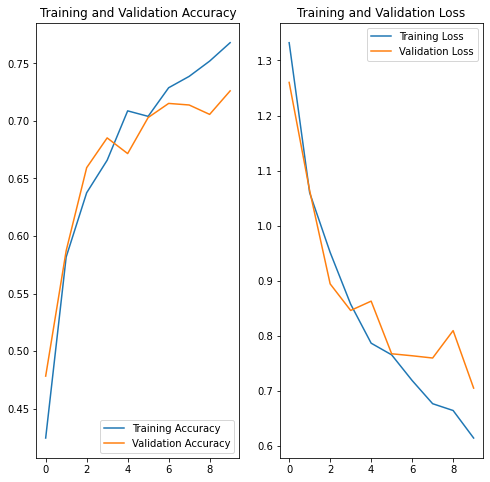

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

131072/117948 [=================================] - 0s 1us/step
This image most likely belongs to sunflowers with a 89.27 percent confidence.


In [17]:
model_save_path = "flowers/1/"
tf.saved_model.save(model, "flowers/1/")

INFO:tensorflow:Assets written to: flowers/1/assets


In [18]:
load_model = tf.saved_model.load(model_save_path)
print(list(load_model.signatures.keys()))

['serving_default']


In [19]:
infer = load_model.signatures['serving_default']

In [20]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

In [21]:
class_names[np.argmax(score)]

'sunflowers'